# VAE(Variational Auto Encoder)

### Import module

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

### Set hyperparams

In [ ]:
device = "cuda"    # @param {"type":"string"}
batch_size = 64    # @param {"type":"integer"}
lr = 1e-03         # @param {"type":"number"}
epochs = 10        # @param {"type":"integer"}

in_channels = 1    # @param {"type":"integer"}
z_dim = 128        # @param {"type":"integer"}
hidden_dim = 256

### Step 1. Define MNIST Dataset

In [ ]:
# image transform function
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root = ".", train = True, transform = transform, download = True)
test_dataset = MNIST(root = ".", train = False, transform = transform, download = True)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.42MB/s]


In [4]:
images, labels = next(iter(train_loader))

print("Images shape: {}".format(images.shape))
print("labels shape: {}".format(labels.shape))

Images shape: torch.Size([64, 1, 28, 28])
labels shape: torch.Size([64])


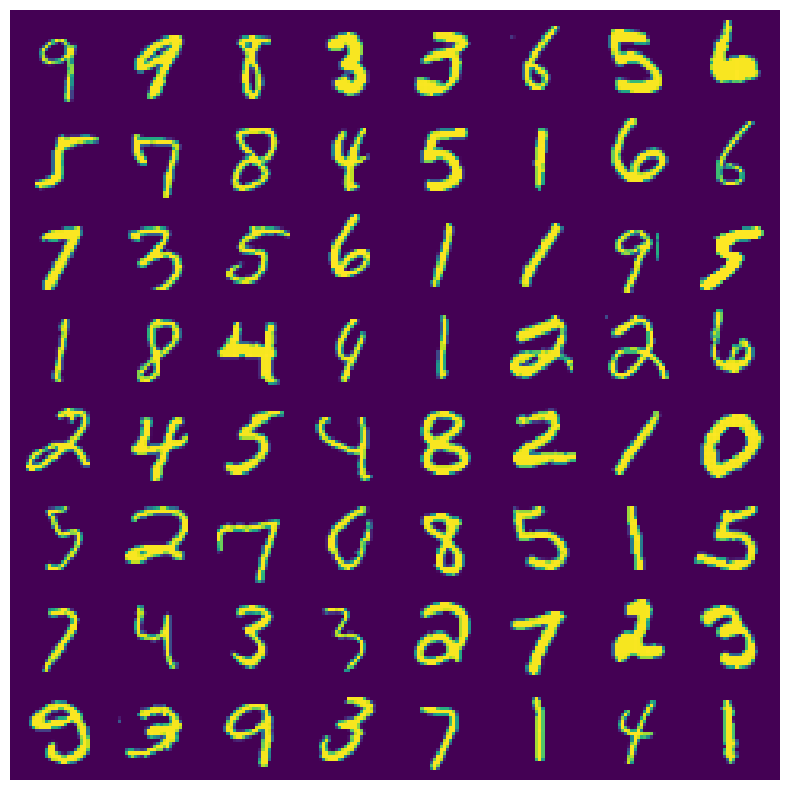

In [5]:
# Show images
def show_image(images, nrow=8, normalize=True, figsize = (8, 8), **kwargs):
    grid = make_grid(images, nrow=nrow, normalize=normalize, **kwargs)

    plt.figure(figsize=figsize)
    plt.imshow(grid[0])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

show_image(images)

### Step 2. Define Variational AutoEncoder (VAE)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_dim=256):
        super().__init__()
        input_size = in_channels * 28 * 28 # C x H x W

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.flatten(x) # B x C x H x W -> B x CHW
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels=1, z_dim=128, hidden_dim=256):
        super().__init__()
        input_size = in_channels * 28 * 28 # C x H x W

        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)
        return x


class VAE(nn.Module):
    def __init__(self, in_channels=1, z_dim=128, hidden_dim=256):
        super().__init__()
        input_size = in_channels*28*28 # C x H x W

        # Encoder
        self.encoder = Encoder(in_channels, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim)
        # Decoder
        self.decoder = Decoder(in_channels, z_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        """
        z = mean + std dev. x noise;   noise ~ N(0,I)
        """
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(sigma).to(logvar.device)
        return mu + sigma * eps

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        out = self.decoder(z)
        out = out.view(-1, 1, 28, 28) # B x CHW -> B x C x H xW
        out = torch.sigmoid(out) # value to [0, 1]
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

### Step 3. Define Loss function & Model & Optimizer

In [ ]:
def loss_function(pred, target, mu, logvar):
    recon_loss = F.binary_cross_entropy(pred, target, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

model = VAE(in_channels=in_channels, z_dim=z_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, epoch, device):
    model.train()
    total_samples = 0
    total_loss = 0.

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.size(0)

        optimizer.zero_grad()
        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += batch_size

        if batch_idx % 100 == 0:
            print(f"[Train] Epoch {epoch} [{total_samples:>5d}/{len(dataloader.dataset)}]\tAvg Loss: {total_loss/total_samples:.3f}")

    total_loss /= total_samples
    return total_loss

@torch.no_grad()
def test_epoch(model, dataloader, criterion, epoch, device):
    model.eval()
    total_samples = 0
    total_loss = 0.

    pbar = tqdm(dataloader, desc = f"[Test]  Epoch {epoch}")

    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device)
        batch_size = data.size(0)

        recon_data, mu, logvar = model(data)
        loss = criterion(recon_data, data, mu, logvar)

        total_loss += loss.item()
        total_samples += batch_size

        pbar.set_postfix(avg_loss=f"{total_loss/total_samples:.3f}")

    total_loss /= total_samples
    return total_loss

In [13]:
for epoch in range(1, epochs+1):
    _ = train_epoch(model, train_loader, loss_function, optimizer, epoch, device)
    _ = test_epoch(model, test_loader, loss_function, epoch, device)

[Train] Epoch 1 [   64/60000]	Avg Loss: 545.561
[Train] Epoch 1 [ 6464/60000]	Avg Loss: 235.194
[Train] Epoch 1 [12864/60000]	Avg Loss: 216.076
[Train] Epoch 1 [19264/60000]	Avg Loss: 206.647
[Train] Epoch 1 [25664/60000]	Avg Loss: 200.120
[Train] Epoch 1 [32064/60000]	Avg Loss: 195.137
[Train] Epoch 1 [38464/60000]	Avg Loss: 190.134
[Train] Epoch 1 [44864/60000]	Avg Loss: 185.598
[Train] Epoch 1 [51264/60000]	Avg Loss: 181.604
[Train] Epoch 1 [57664/60000]	Avg Loss: 177.983


[Test]  Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 104.92it/s, avg_loss=143.865]


[Train] Epoch 2 [   64/60000]	Avg Loss: 149.136
[Train] Epoch 2 [ 6464/60000]	Avg Loss: 143.620
[Train] Epoch 2 [12864/60000]	Avg Loss: 140.838
[Train] Epoch 2 [19264/60000]	Avg Loss: 139.418
[Train] Epoch 2 [25664/60000]	Avg Loss: 137.970
[Train] Epoch 2 [32064/60000]	Avg Loss: 136.606
[Train] Epoch 2 [38464/60000]	Avg Loss: 135.489
[Train] Epoch 2 [44864/60000]	Avg Loss: 134.468
[Train] Epoch 2 [51264/60000]	Avg Loss: 133.472
[Train] Epoch 2 [57664/60000]	Avg Loss: 132.674


[Test]  Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 105.59it/s, avg_loss=124.370]


[Train] Epoch 3 [   64/60000]	Avg Loss: 123.319
[Train] Epoch 3 [ 6464/60000]	Avg Loss: 124.886
[Train] Epoch 3 [12864/60000]	Avg Loss: 124.975
[Train] Epoch 3 [19264/60000]	Avg Loss: 124.497
[Train] Epoch 3 [25664/60000]	Avg Loss: 123.933
[Train] Epoch 3 [32064/60000]	Avg Loss: 123.370
[Train] Epoch 3 [38464/60000]	Avg Loss: 123.062
[Train] Epoch 3 [44864/60000]	Avg Loss: 122.602
[Train] Epoch 3 [51264/60000]	Avg Loss: 122.145
[Train] Epoch 3 [57664/60000]	Avg Loss: 121.763


[Test]  Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 117.92it/s, avg_loss=117.525]


[Train] Epoch 4 [   64/60000]	Avg Loss: 128.579
[Train] Epoch 4 [ 6464/60000]	Avg Loss: 118.080
[Train] Epoch 4 [12864/60000]	Avg Loss: 117.735
[Train] Epoch 4 [19264/60000]	Avg Loss: 117.497
[Train] Epoch 4 [25664/60000]	Avg Loss: 117.224
[Train] Epoch 4 [32064/60000]	Avg Loss: 117.076
[Train] Epoch 4 [38464/60000]	Avg Loss: 116.888
[Train] Epoch 4 [44864/60000]	Avg Loss: 116.682
[Train] Epoch 4 [51264/60000]	Avg Loss: 116.515
[Train] Epoch 4 [57664/60000]	Avg Loss: 116.270


[Test]  Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 115.92it/s, avg_loss=113.526]


[Train] Epoch 5 [   64/60000]	Avg Loss: 117.614
[Train] Epoch 5 [ 6464/60000]	Avg Loss: 114.139
[Train] Epoch 5 [12864/60000]	Avg Loss: 114.225
[Train] Epoch 5 [19264/60000]	Avg Loss: 114.164
[Train] Epoch 5 [25664/60000]	Avg Loss: 113.910
[Train] Epoch 5 [32064/60000]	Avg Loss: 113.519
[Train] Epoch 5 [38464/60000]	Avg Loss: 113.396
[Train] Epoch 5 [44864/60000]	Avg Loss: 113.183
[Train] Epoch 5 [51264/60000]	Avg Loss: 113.016
[Train] Epoch 5 [57664/60000]	Avg Loss: 112.900


[Test]  Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 114.80it/s, avg_loss=111.511]


[Train] Epoch 6 [   64/60000]	Avg Loss: 111.241
[Train] Epoch 6 [ 6464/60000]	Avg Loss: 111.022
[Train] Epoch 6 [12864/60000]	Avg Loss: 111.197
[Train] Epoch 6 [19264/60000]	Avg Loss: 111.142
[Train] Epoch 6 [25664/60000]	Avg Loss: 111.075
[Train] Epoch 6 [32064/60000]	Avg Loss: 110.989
[Train] Epoch 6 [38464/60000]	Avg Loss: 110.915
[Train] Epoch 6 [44864/60000]	Avg Loss: 110.865
[Train] Epoch 6 [51264/60000]	Avg Loss: 110.825
[Train] Epoch 6 [57664/60000]	Avg Loss: 110.715


[Test]  Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 112.58it/s, avg_loss=109.339]


[Train] Epoch 7 [   64/60000]	Avg Loss: 105.738
[Train] Epoch 7 [ 6464/60000]	Avg Loss: 109.454
[Train] Epoch 7 [12864/60000]	Avg Loss: 109.474
[Train] Epoch 7 [19264/60000]	Avg Loss: 109.542
[Train] Epoch 7 [25664/60000]	Avg Loss: 109.513
[Train] Epoch 7 [32064/60000]	Avg Loss: 109.378
[Train] Epoch 7 [38464/60000]	Avg Loss: 109.381
[Train] Epoch 7 [44864/60000]	Avg Loss: 109.345
[Train] Epoch 7 [51264/60000]	Avg Loss: 109.323
[Train] Epoch 7 [57664/60000]	Avg Loss: 109.259


[Test]  Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 91.05it/s, avg_loss=108.128]


[Train] Epoch 8 [   64/60000]	Avg Loss: 103.915
[Train] Epoch 8 [ 6464/60000]	Avg Loss: 107.852
[Train] Epoch 8 [12864/60000]	Avg Loss: 108.260
[Train] Epoch 8 [19264/60000]	Avg Loss: 108.248
[Train] Epoch 8 [25664/60000]	Avg Loss: 108.135
[Train] Epoch 8 [32064/60000]	Avg Loss: 108.184
[Train] Epoch 8 [38464/60000]	Avg Loss: 108.279
[Train] Epoch 8 [44864/60000]	Avg Loss: 108.233
[Train] Epoch 8 [51264/60000]	Avg Loss: 108.228
[Train] Epoch 8 [57664/60000]	Avg Loss: 108.183


[Test]  Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 114.80it/s, avg_loss=107.484]


[Train] Epoch 9 [   64/60000]	Avg Loss: 98.344
[Train] Epoch 9 [ 6464/60000]	Avg Loss: 107.319
[Train] Epoch 9 [12864/60000]	Avg Loss: 107.726
[Train] Epoch 9 [19264/60000]	Avg Loss: 107.647
[Train] Epoch 9 [25664/60000]	Avg Loss: 107.757
[Train] Epoch 9 [32064/60000]	Avg Loss: 107.707
[Train] Epoch 9 [38464/60000]	Avg Loss: 107.672
[Train] Epoch 9 [44864/60000]	Avg Loss: 107.539
[Train] Epoch 9 [51264/60000]	Avg Loss: 107.546
[Train] Epoch 9 [57664/60000]	Avg Loss: 107.511


[Test]  Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 115.48it/s, avg_loss=107.266]


[Train] Epoch 10 [   64/60000]	Avg Loss: 101.930
[Train] Epoch 10 [ 6464/60000]	Avg Loss: 106.716
[Train] Epoch 10 [12864/60000]	Avg Loss: 106.895
[Train] Epoch 10 [19264/60000]	Avg Loss: 106.827
[Train] Epoch 10 [25664/60000]	Avg Loss: 106.767
[Train] Epoch 10 [32064/60000]	Avg Loss: 106.680
[Train] Epoch 10 [38464/60000]	Avg Loss: 106.748
[Train] Epoch 10 [44864/60000]	Avg Loss: 106.747
[Train] Epoch 10 [51264/60000]	Avg Loss: 106.772
[Train] Epoch 10 [57664/60000]	Avg Loss: 106.720


[Test]  Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 117.11it/s, avg_loss=106.400]


### Step 5. Generate images from test dataset

Reconstruction


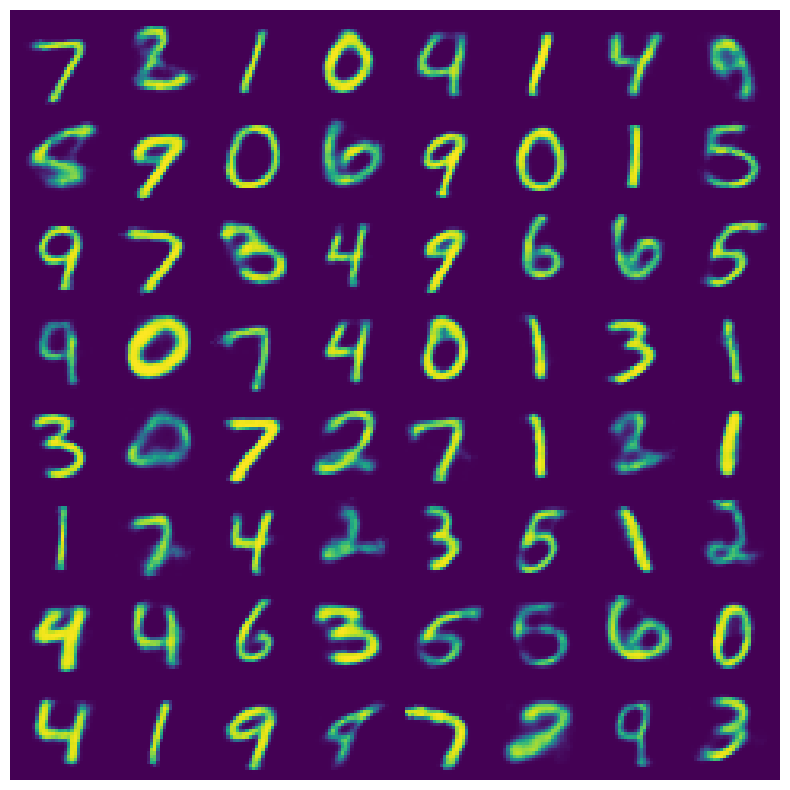

Ground Truth


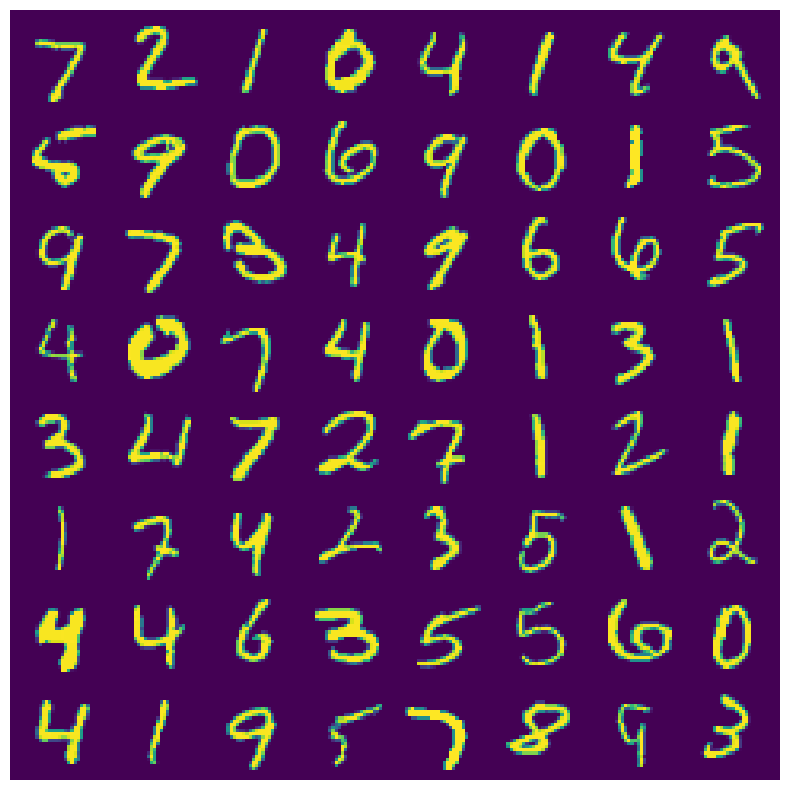

In [ ]:
images, label = next(iter(test_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    recon_images, _, _ = model(images)

print("Reconstruction")
show_image(recon_images.detach().cpu())

print("Ground Truth")
show_image(images.detach().cpu())

### Step 6. Generate image from noise vector

Generation Images from Random Noise


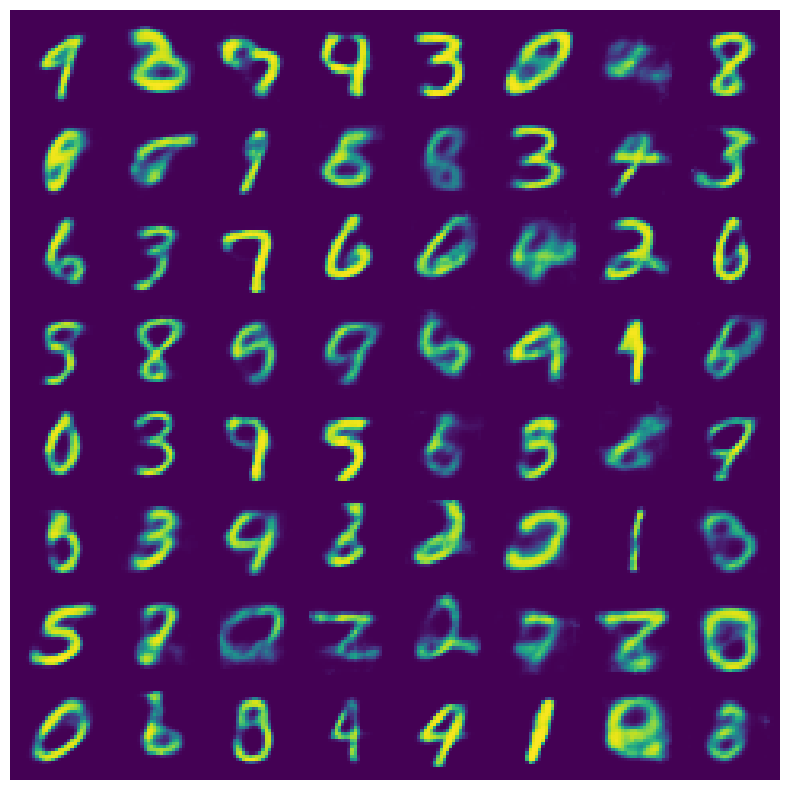

In [ ]:
model.eval()
with torch.no_grad():
    noise = torch.randn(batch_size, z_dim).to(device)
    generated_images = model.decode(noise)

print("Generation Images from Random Noise")
show_image(generated_images.detach().cpu())